In [49]:
from dotenv import load_dotenv
import os
load_dotenv()
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")

In [50]:
from langchain_community.document_loaders import PyPDFLoader

loader = PyPDFLoader(
    "C:/Users/waled/Desktop/chamwings/Policies.pdf",
)

In [51]:
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_chroma import Chroma

embedding_function = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
vector_store = Chroma(embedding_function=embedding_function,persist_directory="C:/Users/waled/Desktop/chamwings/EmployeeChatBot/policies",  # Where to save data locally, remove if not neccesary
)

retriever = vector_store.as_retriever()

In [52]:
import os
import datetime
from typing import List, Dict, Any
from sqlalchemy import create_engine, text
from langchain_core.tools import tool
from langchain_core.runnables import ensure_config
DATABASE_URL = os.getenv("DATABASE_URL", "mysql://root:@localhost/chamwings")
engine = create_engine(DATABASE_URL)
@tool
def fetch_user_flight_information() -> List[Dict[str, Any]]:
    """Fetch all reservations for the user along with corresponding flight information and seat assignments.

    Returns:
        A list of dictionaries where each dictionary contains the reservation details,
        associated flight details, and the seat assignments for each reservation belonging to the user.
    """
    config = ensure_config()  # Fetch from the context
    configuration = config.get("configurable", {})
    passenger_id = configuration.get("passenger_id", None)
    if not passenger_id:
        raise ValueError("No passenger ID configured.")
        
    query = text("""
        SELECT 
            r.reservation_id AS ticket_no, 
            r.status AS booking_status,
            f.flight_id, 
            f.flight_number, 
            dep_airport.airport_name AS departure_airport, 
            arr_airport.airport_name AS arrival_airport,
            s.departure_date AS scheduled_departure, 
            s.arrival_date AS scheduled_arrival,
            fs.seat_id AS seat_no, 
            fs.status AS seat_status
        FROM 
            reservations r
            JOIN flights f ON r.flight_id = f.flight_id
            JOIN airports dep_airport ON f.departure_airport = dep_airport.airport_id
            JOIN airports arr_airport ON f.arrival_airport = arr_airport.airport_id
            JOIN schedule_days s ON f.flight_id = s.flight_id
            LEFT JOIN flight_seats fs ON f.flight_id = fs.flight_id
        WHERE 
            r.passenger_id = :passenger_id
    """)

    with engine.connect() as connection:
        result = connection.execute(query, {"passenger_id": passenger_id})
        return [dict(row._mapping) for row in result]  # Use row._mapping to access row as a dictionary
@tool
def search_flights(departure_airport: int, arrival_airport: int, departure_date: datetime.date) -> List[Dict[str, Any]]:
    """
    Search for available flights based on departure and arrival airports and date.
    """
    query = text("""
        SELECT f.flight_id, f.flight_number, f.departure_terminal, f.arrival_terminal, 
               f.price, (a.capacity - f.number_of_reserved_seats) as available_seats
        FROM flights f
        JOIN airplanes a ON f.airplane_id = a.airplane_id
        WHERE f.departure_airport = :departure_airport
        AND f.arrival_airport = :arrival_airport
        AND DATE(f.departure_terminal) = :departure_date
    """)
    
    with engine.connect() as connection:
        result = connection.execute(query, {
            "departure_airport": departure_airport,
            "arrival_airport": arrival_airport,
            "departure_date": departure_date
        })
        # return [dict(row) for row in result]
        return [dict(row._mapping) for row in result]  # Use row._mapping to access row as a dictionary
@tool
def lookup_policy(query: str) -> str:
    """Consult the company policies to check whether certain options are permitted.
    Use this before making any flight changes performing other 'write' events."""
    docs = retriever.query(query, k=2)
    return "\n\n".join([doc["page_content"] for doc in docs])
@tool
def update_reservation_to_new_flight(reservation_id: int, new_flight_id: int) -> bool:
    """
    Update a reservation to a new flight.
    """
    with engine.begin() as connection:
        # Check if the reservation exists
        check_reservation = text("SELECT flight_id FROM reservations WHERE reservation_id = :reservation_id")
        old_flight_id = connection.execute(check_reservation, {"reservation_id": reservation_id}).scalar()
        if not old_flight_id:
            return False

        # Check if the new flight exists and has available seats
        check_flight = text("""
            SELECT (a.capacity - f.number_of_reserved_seats) as available_seats
            FROM flights f
            JOIN airplanes a ON f.airplane_id = a.airplane_id
            WHERE f.flight_id = :flight_id
        """)
        available_seats = connection.execute(check_flight, {"flight_id": new_flight_id}).scalar()
        if available_seats is None or available_seats <= 0:
            return False

        # Update the reservation
        update_reservation = text("""
            UPDATE reservations 
            SET flight_id = :new_flight_id 
            WHERE reservation_id = :reservation_id
        """)
        connection.execute(update_reservation, {
            "new_flight_id": new_flight_id,
            "reservation_id": reservation_id
        })

        # Update the seat counts
        update_old_flight = text("""
            UPDATE flights 
            SET number_of_reserved_seats = number_of_reserved_seats - 1 
            WHERE flight_id = :flight_id
        """)
        update_new_flight = text("""
            UPDATE flights 
            SET number_of_reserved_seats = number_of_reserved_seats + 1 
            WHERE flight_id = :flight_id
        """)
        connection.execute(update_old_flight, {"flight_id": old_flight_id})
        connection.execute(update_new_flight, {"flight_id": new_flight_id})

    return True
@tool
def cancel_reservation(reservation_id: int) -> bool:
    """
    Cancel a reservation (reservation).
    """
    with engine.begin() as connection:
        # Check if the reservation exists
        check_reservation = text("SELECT flight_id, status FROM reservations WHERE reservation_id = :reservation_id")
        result = connection.execute(check_reservation, {"reservation_id": reservation_id}).first()
        if not result:
            return False
        flight_id, status = result

        if status == 'Cancelled':
            return False  # Already cancelled

        # Update the reservation status
        update_reservation = text("""
            UPDATE reservations 
            SET status = 'Cancelled' 
            WHERE reservation_id = :reservation_id
        """)
        connection.execute(update_reservation, {"reservation_id": reservation_id})

        # Update the flight's reserved seats count
        update_flight = text("""
            UPDATE flights 
            SET number_of_reserved_seats = number_of_reserved_seats - 1 
            WHERE flight_id = :flight_id
        """)
        connection.execute(update_flight, {"flight_id": flight_id})

    return True

In [60]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph.message import AnyMessage, add_messages


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    user_info: str


class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            result = self.runnable.invoke(state)
            # If the LLM happens to return an empty response, we will re-prompt it
            # for an actual response.
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}


import multiprocessing
from langchain_community.chat_models import ChatLlamaCpp
local_model = "C:/Users/waled/.cache/lm-studio/models/lmstudio-ai/gemma-2b-it-GGUF/gemma-2b-it-q4_k_m.gguf"
local_model = "C:/Users/waled/.cache/lm-studio/models/NousResearch/Hermes-2-Pro-Llama-3-8B-GGUF/Hermes-2-Pro-Llama-3-8B-Q6_K.gguf"
llm = ChatLlamaCpp(
    temperature=0.5,
    model_path=local_model,
    n_ctx=10000,
    n_gpu_layers=8,
    n_batch=300,  # Should be between 1 and n_ctx, consider the amount of VRAM in your GPU.
    max_tokens=512,
    n_threads=multiprocessing.cpu_count() - 1,
    repeat_penalty=1.5,
    top_p=0.5,
    verbose=True,
)



assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful customer support assistant for Cham Wings Airlines. "
            " Use the provided tools to search for flights, company policies, and other information to assist the user's queries. "
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            " If a search comes up empty, expand your search before giving up."
            "\n\nCurrent user:\n\n{user_info}\n",
       
        ),
        ("placeholder", "{messages}"),
    ]
)

# "Read"-only tools (such as retrievers) don't need a user confirmation to use
part_3_safe_tools = [
    TavilySearchResults(max_results=1),
    fetch_user_flight_information,
    search_flights,
    lookup_policy,
]

# These tools all change the user's reservations.
# The user has the right to control what decisions are made
part_3_sensitive_tools = [
    update_reservation_to_new_flight,
    cancel_reservation,
]
sensitive_tool_names = {t.name for t in part_3_sensitive_tools}
# Our LLM doesn't have to know which nodes it has to route to. In its 'mind', it's just invoking functions.
part_3_assistant_runnable = assistant_prompt | llm.bind_tools(
    part_3_safe_tools + part_3_sensitive_tools
)

llama_model_loader: loaded meta data with 23 key-value pairs and 291 tensors from C:/Users/waled/.cache/lm-studio/models/NousResearch/Hermes-2-Pro-Llama-3-8B-GGUF/Hermes-2-Pro-Llama-3-8B-Q6_K.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = Hermes-2-Pro-Llama-3-8B
llama_model_loader: - kv   2:                          llama.block_count u32              = 32
llama_model_loader: - kv   3:                       llama.context_length u32              = 8192
llama_model_loader: - kv   4:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 14336
llama_model_loader: - kv   6:                 llama.attention.head_count u32 

In [54]:
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda

from langgraph.prebuilt import ToolNode


def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }


def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )


def _print_event(event: dict, _printed: set, max_length=1500):
    current_state = event.get("dialog_state")
    if current_state:
        print("Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)

In [63]:
from typing import Literal

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph
from langgraph.prebuilt import tools_condition

builder = StateGraph(State)


def user_info(state: State):
    return {"user_info": fetch_user_flight_information.invoke({})}


# NEW: The fetch_user_info node runs first, meaning our assistant can see the user's flight information without
# having to take an action
builder.add_node("fetch_user_info", user_info)
builder.add_edge(START, "fetch_user_info")
builder.add_node("assistant", Assistant(part_3_assistant_runnable))
builder.add_node("safe_tools", create_tool_node_with_fallback(part_3_safe_tools))
builder.add_node(
    "sensitive_tools", create_tool_node_with_fallback(part_3_sensitive_tools)
)
# Define logic
builder.add_edge("fetch_user_info", "assistant")


def route_tools(state: State) -> Literal["safe_tools", "sensitive_tools", "__end__"]:
    next_node = tools_condition(state)
    # If no tools are invoked, return to the user
    if next_node == END:
        return END
    ai_message = state["messages"][-1]
    # This assumes single tool calls. To handle parallel tool calling, you'd want to
    # use an ANY condition
    first_tool_call = ai_message.tool_calls[0]
    if first_tool_call["name"] in sensitive_tool_names:
        return "sensitive_tools"
    return "safe_tools"


builder.add_conditional_edges(
    "assistant",
    route_tools,
)
builder.add_edge("safe_tools", "assistant")
builder.add_edge("sensitive_tools", "assistant")

memory = MemorySaver()
part_3_graph = builder.compile(
    checkpointer=memory,
    # NEW: The graph will always halt before executing the "tools" node.
    # The user can approve or reject (or even alter the request) before
    # the assistant continues
    interrupt_before=["sensitive_tools"],
)

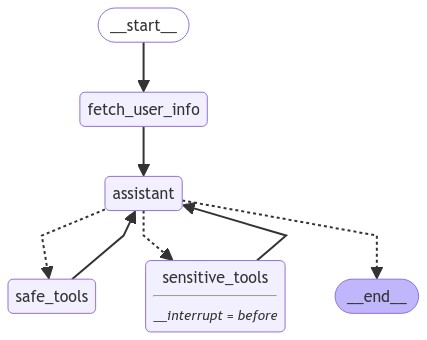

In [66]:
from IPython.display import Image, display

try:
    display(Image(part_3_graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [67]:
import shutil
import uuid

tutorial_questions = [
    "Hi there, what time is my flight?",
    "Am i allowed to update my flight to something sooner? I want to leave later today.",
    "Update my flight to sometime next week then",
    "The next available option is great",
]
# Update with the backup file so we can restart from the original place in each section
# shutil.copy(backup_file, db)
thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        # The passenger_id is used in our flight tools to
        # fetch the user's flight information
        "passenger_id": "1",
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}


_printed = set()
# We can reuse the tutorial questions from part 1 to see how it does.
for question in tutorial_questions:
    events = part_3_graph.stream(
        {"messages": ("user", question)}, config, stream_mode="values"
    )
    for event in events:
        _print_event(event, _printed)
    snapshot = part_3_graph.get_state(config)
    while snapshot.next:
        # We have an interrupt! The agent is trying to use a tool, and the user can approve or deny it
        # Note: This code is all outside of your graph. Typically, you would stream the output to a UI.
        # Then, you would have the frontend trigger a new run via an API call when the user has provided input.
        user_input = input(
            "Do you approve of the above actions? Type 'y' to continue;"
            " otherwise, explain your requested changed.\n\n"
        )
        if user_input.strip() == "y":
            # Just continue
            result = part_3_graph.invoke(
                None,
                config,
            )
        else:
            # Satisfy the tool invocation by
            # providing instructions on the requested changes / change of mind
            result = part_3_graph.invoke(
                {
                    "messages": [
                        ToolMessage(
                            tool_call_id=event["messages"][-1].tool_calls[0]["id"],
                            content=f"API call denied by user. Reasoning: '{user_input}'. Continue assisting, accounting for the user's input.",
                        )
                    ]
                },
                config,
            )
        snapshot = part_3_graph.get_state(config)

================================ Human Message =================================

Hi there, what time is my flight?
